# Interpolate to Observations Directly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
from eagle.tools.data import open_anemoi_inference_dataset

[Tims-MacBook-Pro.local:83636] shmem: mmap: an error occurred while determining whether or not /var/folders/p4/_cggth6n22d8g_hgm1k3vq100000gn/T//ompi.Tims-MacBook-Pro.501/jf.0/441384960/sm_segment.Tims-MacBook-Pro.501.1a4f0000.0 could be created.


In [56]:
obs = xr.open_dataset("observations/obs/20230201/06/gdas.20230201.t06z.prepbufr.nc")

In [57]:
obs.load()

<xarray.Dataset> Size: 11MB
Dimensions:        (nhdr: 61438, nobs: 219668, npbhdr: 61438, nhdr_typ: 4,
                    nhdr_sid: 13527, nhdr_vld: 1615, nobs_qty: 5, obs_var_num: 6)
Dimensions without coordinates: nhdr, nobs, npbhdr, nhdr_typ, nhdr_sid,
                                nhdr_vld, nobs_qty, obs_var_num
Data variables: (12/22)
    hdr_typ        (nhdr) float64 492kB 0.0 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
    hdr_sid        (nhdr) float64 492kB 0.0 1.0 1.0 ... 1.353e+04 1.353e+04
    hdr_vld        (nhdr) float64 492kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hdr_lat        (nhdr) float32 246kB 22.32 33.33 33.33 ... -79.7 -79.7 -79.7
    hdr_lon        (nhdr) float32 246kB 114.2 126.7 126.7 ... -79.0 -83.5 -83.5
    hdr_elv        (nhdr) float32 246kB 66.0 234.0 234.0 ... 660.0 720.0 720.0
    ...             ...
    hdr_sid_table  (nhdr_sid) |S40 541kB b'45004' b'47186' ... b'AASKY' b'AAUN1'
    hdr_vld_table  (nhdr_vld) |S16 26kB b'20230201_060000' ... b'20230201_055...
    obs_qty_table  (nobs_qty) |S16 80B b'2' b'9' b'3' b'1' b'8'
    obs_var        (obs_var_num) |S40 240B b'PRES' b'SPFH' ... b'UGRD' b'VGRD'
    obs_unit       (obs_var_num) |S40 240B b'PASCALS' b'KG/KG' ... b'M/S' b'M/S'
    obs_desc       (obs_var_num) |S80 480B b'PRESSURE OBSERVATION' ... b'V-CO...
Attributes:
    MET_Obs_version:  1.02
    use_var_id:       true
    FileOrigins:      File / generated 20251126_185605 UTC on host nid004158 ...
    MET_version:      V11.0.3
    MET_tool:         pb2nc

In [58]:
for key in obs.data_vars:
    print(f"{key}: {obs[key].long_name}")

hdr_typ: index of message type
hdr_sid: index of station identification
hdr_vld: index of valid time
hdr_lat: latitude
hdr_lon: longitude
hdr_elv: elevation
obs_qty: index of quality flag
obs_hid: index of matching header data
obs_vid: index of BUFR variable corresponding to the observation type
obs_lvl: pressure level (hPa) or accumulation interval (sec)
obs_hgt: height in meters above sea level (msl)
obs_val: observation value
hdr_prpt_typ: PB report type
hdr_irpt_typ: In report type
hdr_inst_typ: instrument type
hdr_typ_table: message type
hdr_sid_table: station identification
hdr_vld_table: valid time
obs_qty_table: quality flag
obs_var: variable names
obs_unit: variable units
obs_desc: variable descriptions


In [59]:
obs.obs_var

<xarray.DataArray 'obs_var' (obs_var_num: 6)> Size: 240B
array([b'PRES', b'SPFH', b'TMP', b'HGT', b'UGRD', b'VGRD'], dtype='|S40')
Dimensions without coordinates: obs_var_num
Attributes:
    long_name:  variable names

## Temperature Observations

In [60]:
tobs = obs.sel(obs_var_num=2)

In [61]:
tobs = tobs.swap_dims({"nhdr": "hdr_sid"})

This loops through each obs, one at a time

In [77]:
tobs.nobs

<xarray.DataArray 'nobs' (nobs: 219668)> Size: 2MB
array([     0,      1,      2, ..., 219665, 219666, 219667])
Dimensions without coordinates: nobs

In [80]:
pidx.values[0]


np.float64(16.0)

In [124]:
units = tobs["obs_unit"].values

p = 850
threshold = 1

pcond = np.abs(tobs["obs_lvl"] - p) < threshold
pidx = tobs["nobs"].where(pcond, drop=True)

vals = []
lvls = []
lats = []
lons = []
unfound = []

for idx in pidx.values:
    thisone = tobs.sel(nobs=int(idx))
    
    hid = thisone["obs_hid"].values
    if hid not in tobs.hdr_sid.values:
        unfound.append(hid)
        print(f"Can't find {hid}, skipping")
    else:
        vals.append(thisone["obs_val"].values)
        lvls.append(thisone["obs_lvl"].values)

        try:
            thislat = float(tobs["hdr_lat"].sel(hdr_sid=hid).values)
            thislon = float(tobs["hdr_lon"].sel(hdr_sid=hid).values)
        except:
            print(tobs["hdr_lat"].sel(hdr_sid=hid).values)
            print(tobs["hdr_lon"].sel(hdr_sid=hid).values)
            raise
        
        lats.append(thislat)
        lons.append(thislon)


[33.33 33.33]
[126.68 126.68]


TypeError: only length-1 arrays can be converted to Python scalars

In [128]:
len(tobs.hdr_sid)

61438

In [129]:
len(np.unique(tobs.hdr_sid.values))

13527

In [126]:
tobs["hdr_lat"].sel(hdr_sid=1.)

<xarray.DataArray 'hdr_lat' (hdr_sid: 2)> Size: 8B
array([33.33, 33.33], dtype=float32)
Coordinates:
  * hdr_sid  (hdr_sid) float64 16B 1.0 1.0
Attributes:
    long_name:  latitude
    units:      degrees_north

In [125]:
hid

array(1.)

In [120]:
thislat

()

In [112]:
float(tobs["hdr_lat"].sel(hdr_sid=hid).values)

22.31999969482422

In [100]:
len(lons)

288

In [101]:
len(lats)

288

In [102]:
lats

[array(22.32, dtype=float32),
 array(22.32, dtype=float32),
 array(22.32, dtype=float32),
 array([33.33, 33.33], dtype=float32),
 array([33.33, 33.33], dtype=float32),
 array([33.33, 33.33], dtype=float32),
 array([33.33, 33.33], dtype=float32),
 array([34.69, 34.69, 34.69, 34.69], dtype=float32),
 array([34.69, 34.69, 34.69, 34.69], dtype=float32),
 array([34.69, 34.69, 34.69, 34.69], dtype=float32),
 array([42.82, 42.82, 42.65, 42.65], dtype=float32),
 array([42.82, 42.82, 42.65, 42.65], dtype=float32),
 array([42.82, 42.82, 42.65, 42.65], dtype=float32),
 array([42.82, 42.82, 42.65, 42.65], dtype=float32),
 array([48.83, 48.83], dtype=float32),
 array([48.83, 48.83], dtype=float32),
 array([48.83, 48.83], dtype=float32),
 array([49.7    , 49.7    , 49.69278, 49.69278], dtype=float32),
 array([49.7    , 49.7    , 49.69278, 49.69278], dtype=float32),
 array([49.7    , 49.7    , 49.69278, 49.69278], dtype=float32),
 array([49.7    , 49.7    , 49.69278, 49.69278], dtype=float32),
 array

In [96]:
x, y = np.meshgrid(lons, lats)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

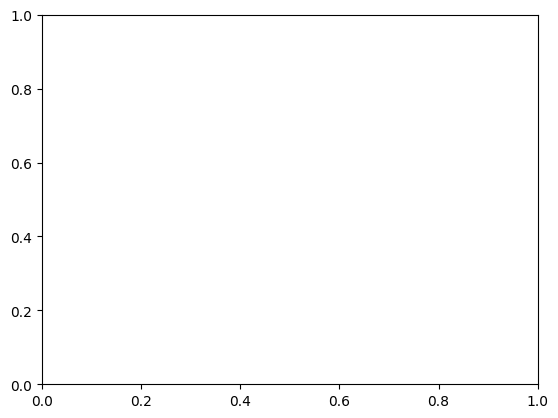

In [94]:
plt.scatter(lons, lats, c=vals)

In [89]:
len(np.unique(unfound))

80

In [83]:
lats

[<xarray.DataArray 'hdr_lat' ()> Size: 4B
 array(22.32, dtype=float32)
 Coordinates:
     hdr_sid  float64 8B 0.0
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarray.DataArray 'hdr_lat' ()> Size: 4B
 array(22.32, dtype=float32)
 Coordinates:
     hdr_sid  float64 8B 0.0
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarray.DataArray 'hdr_lat' ()> Size: 4B
 array(22.32, dtype=float32)
 Coordinates:
     hdr_sid  float64 8B 0.0
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarray.DataArray 'hdr_lat' (hdr_sid: 2)> Size: 8B
 array([33.33, 33.33], dtype=float32)
 Coordinates:
   * hdr_sid  (hdr_sid) float64 16B 1.0 1.0
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarray.DataArray 'hdr_lat' (hdr_sid: 2)> Size: 8B
 array([33.33, 33.33], dtype=float32)
 Coordinates:
   * hdr_sid  (hdr_sid) float64 16B 1.0 1.0
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarra

In [84]:
len(vals)

289

But it makes sense to loop through each station and pull all obs at that location

In [21]:

tp = tobs.where()

KeyboardInterrupt: 

In [ ]:
tp.

(array([1.0700e+03, 7.9800e+02, 8.2000e+02, 3.8000e+02, 3.3700e+02,
        1.6000e+02, 3.1600e+02, 3.7570e+03, 1.3601e+04, 7.8230e+03,
        5.9830e+03, 3.7930e+03, 2.9740e+03, 1.8470e+03, 1.9990e+03,
        1.5420e+03, 1.9160e+03, 1.4700e+03, 1.8770e+03, 2.0510e+03,
        2.2890e+03, 1.5320e+03, 1.7520e+03, 1.5950e+03, 2.2290e+03,
        1.7750e+03, 2.0480e+03, 2.1740e+03, 2.9370e+03, 1.9690e+03,
        1.9930e+03, 2.3720e+03, 2.6750e+03, 3.5390e+03, 4.3270e+03,
        4.8120e+03, 5.7260e+03, 7.7360e+03, 9.7050e+03, 1.2549e+04,
        3.1033e+04, 5.2675e+04, 5.6890e+03, 1.3000e+01, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([-8.50000000e+02, -8.25692017e+02, -8.01383972e+02, -7.77075989e+02,
        -7.52768005e+02, -7.28460022e+02, -7.04151978e+02, -6.79843994e+02,
        -6.55536011e+02, -6.31228027e+02, -6.06919983e+02, -5.82612000e+02,
        -5.58303955e+02, -5.33995972e+02, -5.09687988e+02, -4.85380005e+02,
        -4.610

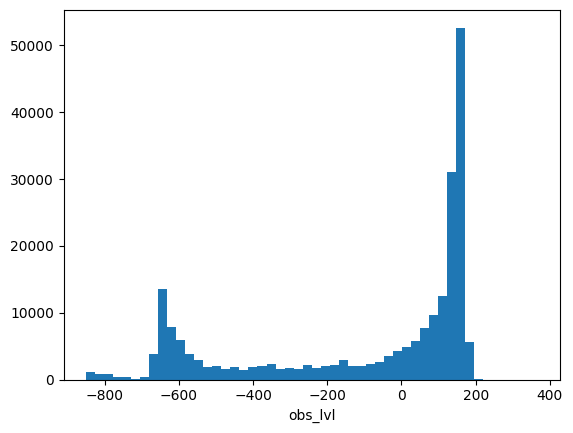

In [36]:
(tobs.obs_lvl - 850).plot.hist(bins=50)

In [22]:
tobs.obs_lvl[:10].values

array([1005.3, 1005.3, 1005.3, 1005.3,  977.7,  977.7,  977.7,  977.7,
        943.2,  943.2], dtype=float32)

In [25]:
obs.obs_lvl.values

array([1005.3, 1005.3, 1005.3, ...,  892.5,  892.5,  892.5], dtype=float32)

In [146]:
hid = obs["obs_hid"].astype(int)
lat = obs["hdr_lat"][hid]
lon = obs["hdr_lon"][hid]
# TBD
# vtime = obs["hdr_vld"][hid]

In [325]:
def filter_observations(
    xds: xr.Dataset,
    pressure: float | int,
    varname: str,
    pressure_threshold: float | int = 5,
) -> xr.Dataset:
    """TODO: mask for quality control
    """
    
    vid = xds["obs_var_num"].where(xds["obs_var"].astype(str) == varname, drop=True).values[0].astype(int)
    
    pcond = np.abs(xds["obs_lvl"] - p) < pressure_threshold
    vcond = xds["obs_vid"].astype(int) == vid
    
    cond = (pcond & vcond)
    fds = xds.isel(nobs=cond)

    hid = obs["obs_hid"].astype(int)
    
    vtime_table = [pd.Timestamp(xtime.astype(str).replace("_","T")) for xtime in obs["hdr_vld_table"].values]
    vtime_hdr = xr.DataArray([vtime_table[idx] for idx in obs["hdr_vld"].values.astype(int)], coords=obs["hdr_vld"].coords)
    
    result = xr.Dataset(
        {
            "obsvals": fds["obs_val"],
            "pressure": fds["obs_lvl"],
            "height": fds["obs_hgt"],
            "latitude": xds["hdr_lat"][hid].isel(nobs=cond),
            "longitude": xds["hdr_lon"][hid].isel(nobs=cond) + 180,
            "quality": xds["obs_qty"][hid].isel(nobs=cond),
            "time": vtime_hdr[hid].isel(nobs=cond),
            
        },
        attrs={
            "name": varname,
            "long_name": xds["obs_desc"][vid].values.astype(str),
            "units": xds["obs_unit"][vid].values.astype(str),
        },
    )
    return result

In [326]:
tt = filter_observations(obs, 850, "TMP", pressure_threshold=1)

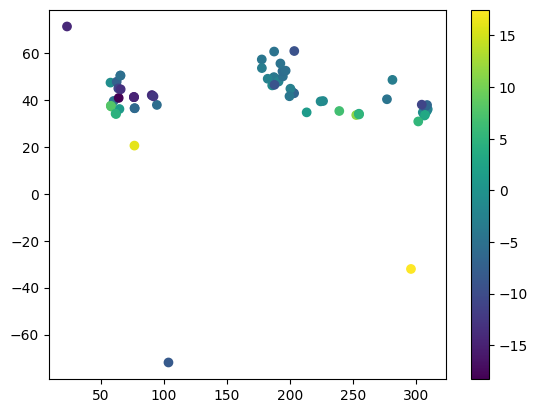

In [327]:
plt.scatter(tt.longitude, tt.latitude, c=(tt.obsvals-273.15))
plt.colorbar()

## Inference datasets

In [307]:
gds = xr.open_dataset("../../sample-inference/nested-global.2023-02-01T06.240h.nc")

In [308]:
model = gds["t"].sel(level=850).isel(time=0).load()

In [328]:
mobs = model.interp(longitude=tt.longitude, latitude=tt.latitude)

In [343]:
[xo.quality.values for xo in allobs.values()]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3,
        0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0,
        3, 0, 3, 0, 3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3],
       dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0, 0,
        3, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0,
        3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 1, 3, 0, 3, 3, 0, 3, 3, 0, 3, 0, 0,
        3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 3], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
  

In [340]:
thresholds = [.1, .5, 1, 2, 4, 8, 16]
allobs = {
    thresh: filter_observations(obs, 850, "TMP", pressure_threshold=thresh)
    for thresh in thresholds
}

allmodels = {
    thresh: model.interp(longitude=val.longitude, latitude=val.latitude)
    for thresh, val in allobs.items()
}

diff = [
    thismodel - thisobs.obsvals
    for thismodel, thisobs in zip(allmodels.values(), allobs.values())
]

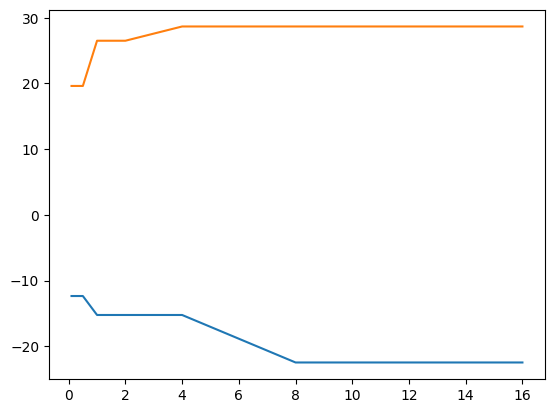

In [341]:
plt.plot(thresholds, [xds.min().values for xds in diff])
plt.plot(thresholds, [xds.max().values for xds in diff])

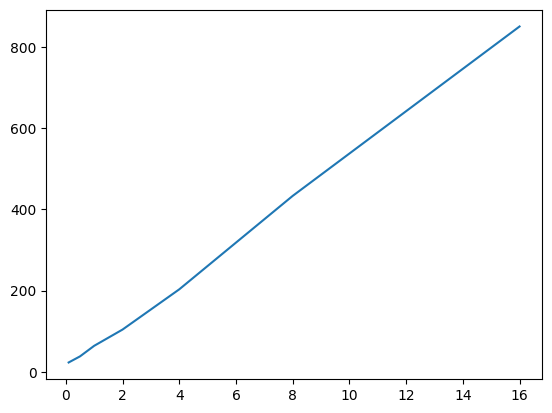

In [342]:
plt.plot(thresholds, [len(xds.nobs) for xds in diff])

In [310]:
mmo = mobs - tt["obsvals"]

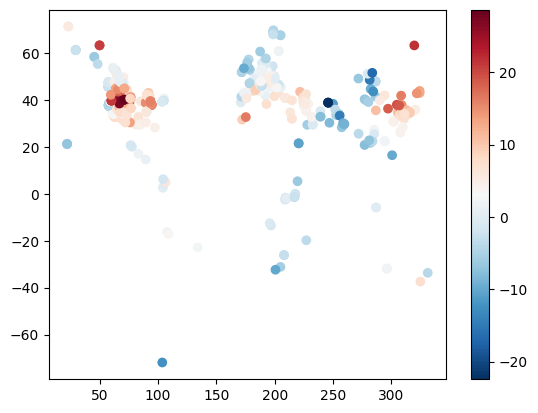

In [311]:
plt.scatter(mmo.longitude, mmo.latitude, c=mmo, cmap="RdBu_r")
plt.colorbar()

In [312]:
mmo

<xarray.DataArray (nobs: 533)> Size: 4kB
array([ 7.71220673e+00,  8.31221284e+00,  9.99909914e+00,  1.01990808e+01,
        5.18116422e+00,  1.82751436e+00,  3.35680908e+00,  1.13726241e+01,
        1.15726363e+01,  9.83115517e+00,  6.69315121e+00,  7.09314511e+00,
        3.66821754e+00,  1.80296160e+00,  2.00297381e+00,  5.52198083e+00,
        5.52198083e+00,  1.15558176e+01,  1.67495900e+01,  1.69496022e+01,
        3.27577394e+00,  3.47575563e+00,  5.44001927e+00,  5.64000096e+00,
        3.69725747e+00, -1.23439135e+01,  1.50133489e+01,  1.96168790e+01,
       -2.68590413e+00, -4.56274944e+00,  1.57746634e+01,  5.97363193e+00,
        1.50292453e+01,  1.51877058e+01,  1.58512754e+01, -2.64311429e+00,
        5.58870011e+00, -5.77794519e+00, -5.17941648e+00,  1.65233879e+01,
        1.57967861e+01, -9.57671910e-01,  1.54721514e+01, -4.78549651e+00,
        4.06050042e+00,  4.82831961e+00,  1.47859414e+01,  1.52829391e+01,
        2.95175629e+00,  2.97324676e+00,  1.61065863e+01,  1.50301945e+01,
        1.40482431e+01,  1.59109397e+01,  2.63643810e+00,  3.34532177e+00,
        4.99435456e+00, -3.79651391e+00,  4.31899299e+00,  5.60829593e+00,
       -6.30675337e+00,  7.40358629e+00, -6.30269761e+00,  1.41967994e+01,
        4.86506914e+00,  6.14441314e+00,  3.01545670e+00,  9.94382228e+00,
       -4.08101909e+00,  5.75384223e+00, -2.87935304e+00, -3.88407062e+00,
        3.81347460e+00, -3.37510031e+00,  2.03068554e+00, -3.35216117e+00,
       -3.50362337e+00,  4.32871644e+00,  5.09526294e+00, -3.23762763e+00,
...
       -1.43077296e+00, -1.39838640e+00,  7.21957814e+00,  6.56290697e+00,
        6.56290697e+00,  3.87325310e+00,  7.91938767e+00,  7.88520861e+00,
        8.21371467e+00,  1.25361153e+01,  2.76664217e+01,  2.85664156e+01,
        2.18111577e+01,  1.49487913e+01,  8.65287442e+00,  1.46542530e+01,
        1.80106293e+01,  1.54734097e+01, -5.40372023e-01,  7.50074139e-01,
       -6.06437256e+00, -1.48636050e+00, -8.07273475e-01,  5.67610858e+00,
        1.85258316e+01, -8.95128380e-01,  9.42828303e+00,  2.85763427e-01,
       -1.87918593e+00, -9.03301362e-01,  7.84149667e+00,  6.19344243e+00,
       -2.76657713e+00, -1.06324444e+01,  5.70460616e+00,  3.74357293e+00,
        3.85014381e+00,  4.36753225e+00, -5.50012102e+00, -1.02296815e+01,
       -3.68784240e+00, -9.42965107e+00, -9.51685132e+00, -8.87925206e+00,
        4.96692534e-01, -2.66754248e+00,  1.41725675e+00,  6.56290697e+00,
        8.56236101e+00,  3.51749435e+00,  5.30701383e+00,  2.74416111e+01,
        2.10993622e+01,  2.10993622e+01,  2.86664217e+01,  8.62744695e+00,
        1.43043503e+01,  1.38715782e+01,  1.28715782e+01, -4.06405404e-01,
        6.12165448e-01,  2.07268008e+01,  5.07142810e+00,  3.22379620e+00,
        1.18182799e+00,  1.54231596e+00, -1.30506082e-01,  5.97265504e+00,
        2.41152223e+00, -6.47745313e+00, -5.42028744e+00,  1.08779727e+01,
        1.11253567e+00,  7.51450263e-01, -3.86565531e+00, -1.60841956e+00,
       -7.09251507e+00])
Coordinates:
    time       datetime64[ns] 8B 2023-02-01T06:00:00
    level      int64 8B 850
    longitude  (nobs) float32 2kB 306.7 306.7 305.5 305.5 ... 283.8 104.4 281.0
    latitude   (nobs) float32 2kB 33.33 33.33 34.69 34.69 ... 22.35 6.22 22.77
Dimensions without coordinates: nobs